In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.api import OLS
import yfinance as yf

In [3]:
phys = yf.download('PHYS', start='2015-01-01', end='2023-01-01')
physx = yf.download('PHYSX', start='2015-01-01', end='2023-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- XPSLVX: No timezone found, symbol may be delisted


In [88]:
# Drop the volume columns in both
phys.drop('Volume', axis=1, inplace=True)
physx.drop('Volume', axis=1, inplace=True)

In [89]:
phys.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2015-01-02,9.69,9.87,9.67,9.82,9.82
2015-01-05,9.84,9.98,9.84,9.97,9.97
2015-01-06,10.00,10.11,9.98,10.07,10.07
2015-01-07,10.01,10.06,10.00,10.02,10.02
2015-01-08,10.04,10.06,9.96,9.97,9.97


In [90]:
physx.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2015-01-02,10.19,10.19,10.19,10.19,6.086246
2015-01-05,10.18,10.18,10.18,10.18,6.080275
2015-01-06,10.15,10.15,10.15,10.15,6.062356
2015-01-07,10.16,10.16,10.16,10.16,6.068328
2015-01-08,10.18,10.18,10.18,10.18,6.080275


In [91]:
df = pd.merge(phys, physx, on='Date', suffixes=('_PHYS', '_PHYSX'))
df.head()

,Open_PHYS,High_PHYS,Low_PHYS,Close_PHYS,Adj Close_PHYS,Open_PHYSX,High_PHYSX,Low_PHYSX,Close_PHYSX,Adj Close_PHYSX
Date,,,,,,,,,,
2015-01-02,9.69,9.87,9.67,9.82,9.82,10.19,10.19,10.19,10.19,6.086246
2015-01-05,9.84,9.98,9.84,9.97,9.97,10.18,10.18,10.18,10.18,6.080275
2015-01-06,10.00,10.11,9.98,10.07,10.07,10.15,10.15,10.15,10.15,6.062356
2015-01-07,10.01,10.06,10.00,10.02,10.02,10.16,10.16,10.16,10.16,6.068328
2015-01-08,10.04,10.06,9.96,9.97,9.97,10.18,10.18,10.18,10.18,6.080275


In [92]:
df.reset_index(inplace=True)
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.head()

,Open_PHYS,High_PHYS,Low_PHYS,Close_PHYS,Adj Close_PHYS,Open_PHYSX,High_PHYSX,Low_PHYSX,Close_PHYSX,Adj Close_PHYSX
Date,,,,,,,,,,
2015-01-02,9.69,9.87,9.67,9.82,9.82,10.19,10.19,10.19,10.19,6.086246
2015-01-05,9.84,9.98,9.84,9.97,9.97,10.18,10.18,10.18,10.18,6.080275
2015-01-06,10.00,10.11,9.98,10.07,10.07,10.15,10.15,10.15,10.15,6.062356
2015-01-07,10.01,10.06,10.00,10.02,10.02,10.16,10.16,10.16,10.16,6.068328
2015-01-08,10.04,10.06,9.96,9.97,9.97,10.18,10.18,10.18,10.18,6.080275


In [93]:
print(f'Number of days in dataset: {len(df)}')

Number of days in dataset: 2014


In [94]:
trainset = np.arange(0, 1500)
df = df.iloc[trainset, :]  # use only first year of data for training

In [95]:
# coint_t: Cointegration test statistic (t-statistic) for the null hypothesis that the two series are not cointegrated.
# pvalue: MacKinnon's approximate p-value
# crit_value: Critical values for the test statistic at the 1 %, 5 %, and 10 % levels.
coint_t, pvalue, crit_value = coint(
    df['Adj Close_PHYS'], df['Adj Close_PHYSX']
    )
print(f'cointegration test statistic: {coint_t}')
print(f'p-value: {pvalue}')
print(f'critical values: {crit_value}')

cointegration test statistic: -1.5766723466762704
p-value: 0.730634877391279
critical values: [-3.90376106 -3.34020915 -3.04728056]


In [ ]:
# Make a new column in the df hedge_ratio that is the calculated using the previous 90 days of close data and the OLS model.

In [ ]:
df['hedge_ratio'] = np.nan
for i in range(0, len(df)):
    last_100_closes_phys = df['Adj Close_PHYS'].iloc[max(0, i-100):i]
    last_100_closes_physx = df['Adj Close_PHYSX'].iloc[max(0, i-100):i]
    model = OLS(last_100_closes_physx, last_100_closes_phys).fit()
    df['hedge_ratio'].iloc[i+100] = model.params[0]
df.head()

In [96]:
df['hedge_ratio'] = np.nan
for i in range(30, len(df)):
    """
    Calculate the hedge ratio using the previous 30 days of data for each day.
    """
    df['hedge_ratio'].iloc[i] = OLS(
        df['Adj Close_PHYS'].iloc[i-30:i],
        df['Adj Close_PHYSX'].iloc[i-30:i]
        ).fit().params[0]
df['hedge_ratio'].fillna(method='bfill', inplace=True)
df.head()

,Open_PHYS,High_PHYS,Low_PHYS,Close_PHYS,Adj Close_PHYS,Open_PHYSX,High_PHYSX,Low_PHYSX,Close_PHYSX,Adj Close_PHYSX,hedge_ratio
Date,,,,,,,,,,,
2015-01-02,9.69,9.87,9.67,9.82,9.82,10.19,10.19,10.19,10.19,6.086246,1.700995
2015-01-05,9.84,9.98,9.84,9.97,9.97,10.18,10.18,10.18,10.18,6.080275,1.700995
2015-01-06,10.00,10.11,9.98,10.07,10.07,10.15,10.15,10.15,10.15,6.062356,1.700995
2015-01-07,10.01,10.06,10.00,10.02,10.02,10.16,10.16,10.16,10.16,6.068328,1.700995
2015-01-08,10.04,10.06,9.96,9.97,9.97,10.18,10.18,10.18,10.18,6.080275,1.700995


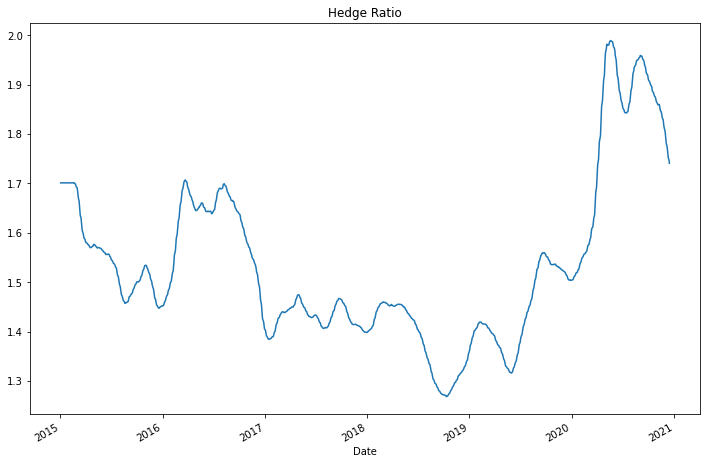

In [97]:
# Plot the hedge ratio
df['hedge_ratio'].plot(figsize=(12, 8))
plt.title('Hedge Ratio')
plt.show()

In [84]:
# Determine the hedge ratio
"""
Using statsmodels OLS to find the hedge ratio.
Where the slope of the regression line (line that minimizes the sum of the squared residuals) from OLS is the hedge ratio.
"""
model = OLS(df['Adj Close_PHYS'], df['Adj Close_PHYSX'])
results = model.fit()
hedge_ratio = results.params[0]
print(f'hedge ratio: {hedge_ratio}')

hedge ratio: 1.5347730864714884


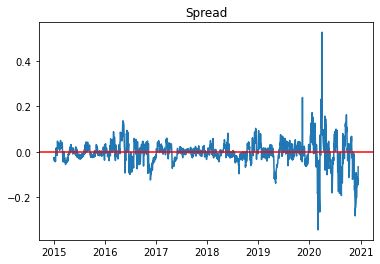

In [68]:
# spread = PHYS - hedge_ratio * PHYSX
spread = df['Adj Close_PHYS'] - df['hedge_ratio'] * df['Adj Close_PHYSX']
plt.plot(spread)
plt.title('Spread')
plt.axhline(0, color='red')
plt.show()

In [ ]:
"""
hedge ratio is innacurate, needs to be calculated on rolling basis
if spread does not regularly revert to 0, must calculate a more reasonable reversion target
  - sma 30, 60, 90
  - ema (could potentially better account for regime changes)
"""